In [166]:
import gurobipy as gp
import numpy as np
from scipy.stats import poisson
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Part I

## 1.

In [3]:
states = [i for i in range(50,-31,-1)]
prob = poisson(10)

In [4]:
tran_matrix = np.zeros((81,81))
temp = []
for i in range(81):
    flag = 50 - states[i]
    temp.append(prob.pmf(flag))
for i in range(51):
    tran_matrix[i] = temp

for i in range(51,81):
    temp = []
    for j in range(81):
        flag = 50 + states[i] - states[j]
        temp.append(prob.pmf(flag))
    tran_matrix[i] = temp

## 2a.

# Part II

<span style="font-family:Times New Roman; font-size:1.4em;">

Let's first specify the model. We will assume the manager will pay for the inventory, backlog and new units he ordered at the same time of ordering the new units. Furthermore, we will define $\delta$	as the number of inventroys after ordering. 
    
</span>

In [493]:
class DP():
    def __init__(self,gama, c, b, h, max_iter = 50):
        self.gama = gama
        self.c = c
        self.b = b
        self.h = h
        self.states_dp = [i for i in range(-30,101)]
        self.max_iter = max_iter
        self.tran_matrixes = [self.tran_matrix_delta(i-30) for i in range(131)]
        self.best_delta = []
            
    def value_iteration(self):
        beta = 0.9
        #innitialize the V(0):
        v_current = np.zeros(131)
        #define the r(x,delta), the reward function:
        r = lambda x, delta: -((delta-x)*self.c + self.h*int(x>=0)*x - x*self.b*int(x<0))
        #interate until converges
        for n in range(self.max_iter):
            v_next = np.zeros(131)
            for i in range(131):
                x = i-30
                v_x_delta = []
                deltas = self.possible_deltas(x)
                for delta in deltas:
                    P = self.tran_matrixes[delta+30]
                    temp = r(x,delta) + beta*P[i].dot(v_current)
                    v_x_delta.append(temp)
                v_next[i] = max(v_x_delta)
            v_current = v_next
            self.v = v_current
        
        for i in range(131):
            x = i-30
            v_x_delta = []
            deltas = self.possible_deltas(x)
            for delta in deltas:
                P = self.tran_matrixes[delta+30]
                temp = r(x,delta) + beta*P[i].dot(self.v)
                v_x_delta.append(temp)
            self.best_delta.append(v_x_delta.index(max(v_x_delta))+x)   
        
    #define possible actions given x:
    def possible_deltas(self, x):
        return self.states_dp[x+30:]
    
    #define a function to generate the corresponding probability matrix when given an action and a mean.
    def tran_matrix_delta(self, delta):
        prob_gama = poisson(self.gama)
        tran_matrix_delta = np.zeros((131,131))
        temp = []
        for i in range(131):
            flag = delta - self.states_dp[i]
            temp.append(prob_gama.pmf(flag))
        temp[0] = 1-sum(temp[1:])        
        for i in range(delta+30+1):
            tran_matrix_delta[i] = temp
        return tran_matrix_delta

In [488]:
models = [DP(15,1,i,j) for (i, j) in [(5,2),(20,2),(2,5),(2,20)]]

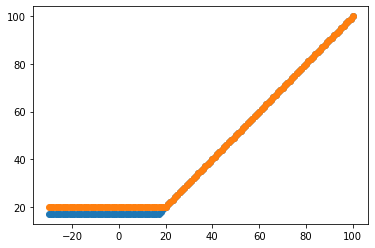

In [489]:
for model in models:
    model.value_iteration()
plt.scatter([i for i in range(-30,101)],models[0].best_delta)
plt.scatter([i for i in range(-30,101)],models[1].best_delta)

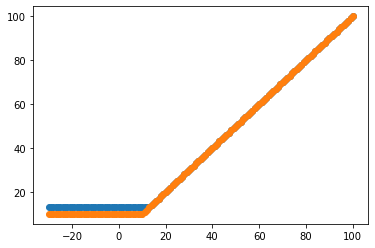

In [490]:
plt.scatter([i for i in range(-30,101)],models[2].best_delta)
plt.scatter([i for i in range(-30,101)],models[3].best_delta)

# Part III

In [470]:
class Q_Learning():
    def __init__(self,gama,c,b,h,max_iter = 200000):
        self.Q = np.zeros((131,131))
        #since the reward is negative, we shall avoid using zero are initial values.
        self.Q -= 800
        self.gama = gama
        self.beta = 0.9
        self.c = c
        self.b = b
        self.h = h
        self.states = [i for i in range(-30,101)]
        self.max_iter = max_iter
        self.t = 1
        self.alpha = 1/self.t**(0.5+ np.finfo(float).eps)
        self.best_delta = []
        self.v = []
        self.test = []
        
    def update(self):
        r = lambda x, delta: -((delta-x)*self.c + self.h*int(x>=0)*x - x*self.b*int(x<0))     
        x_t = random.choice(self.states)
        epsilon = 0.2
        #explore and exploit
        for n in range(self.max_iter):
            if random.uniform(0, 1) < epsilon:
                #explore a random action
                delta_t = random.choice(self.possible_deltas(x_t))
                x_t_1 = max(delta_t - np.random.poisson(self.gama),-30)                
                self.Q[x_t+30,delta_t+30] = self.Q[x_t+30,delta_t+30]\
                + self.alpha*(r(x_t,delta_t)+self.beta*np.max(self.Q[x_t_1+30,x_t_1+30:])-self.Q[x_t+30,delta_t+30])
                self.t += 1
                self.alpha = 1/self.t**(0.5+ np.finfo(float).eps)
                x_t = x_t_1
            else:
                #exploit the current optimal feasible action (optimal actions in the set of actions
                #that are greater or equal to x_t)
                delta_t = np.argmax(self.Q[x_t+30,x_t+30:]) - 30
                x_t_1 = max(delta_t - np.random.poisson(self.gama),-30)                
                self.Q[x_t+30,delta_t+30] = self.Q[x_t+30,delta_t+30]\
                + self.alpha*(r(x_t,delta_t)+self.beta*np.max(self.Q[x_t_1+30,x_t_1+30:])-self.Q[x_t+30,delta_t+30])
                self.t += 1
                self.alpha = 1/self.t**(0.5+ np.finfo(float).eps)
                x_t = x_t_1
        
        for i in range(131):
            self.best_delta.append(np.argmax(self.Q[i])-30)
            self.v.append(max(self.Q[i]))
    
    #define possible actions given x:
    def possible_deltas(self, x):
        return self.states[x+30:]


In [494]:
test = DP(15,1,10,2)
test.value_iteration()

In [471]:
test_2 = Q_Learning(15,1,10,2)
test_2.update()

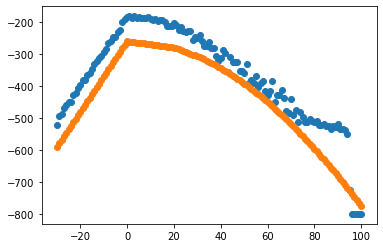

In [472]:
plt.scatter(states,test_2.v)
plt.scatter(states,test.v)

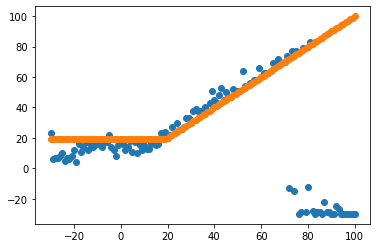

In [473]:
plt.scatter(states,test_2.best_delta)
plt.scatter(states,test.best_delta)